In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import random

shap.initjs()

In [2]:
# ============================
# 1. Load cleaned data
# ============================

data_path = "./data/processed/financial_report_bank_zscore_clean.csv"
df = pd.read_csv(data_path)

print("Shape data:", df.shape)
print(df.head())
df.head()

Shape data: (1812, 27)
  symbol  calendar_year period    time       size       der       dar  \
0   AGRO           2023     Q4  2023Q4  30.151990  0.158755  0.043646   
1   AGRO           2023     Q3  2023Q3  30.067564  0.027119  0.008067   
2   AGRO           2023     Q2  2023Q2  30.116618  0.033987  0.009662   
3   AGRO           2023     Q1  2023Q1  30.168138  0.033731  0.009062   
4   AGRO           2022     Q4  2022Q4  30.262822  0.032612  0.007952   

        roa       roe      sdoa  ...  operating_income_ratio  quarter  \
0  0.000778  0.002830  0.000161  ...               -0.070020        4   
1  0.000472  0.001587  0.000052  ...                0.109110        3   
2  0.000408  0.001436  0.000891  ...                0.748114        2   
3  0.000346  0.001287  0.001173  ...                0.859516        1   
4 -0.001512 -0.006200  0.001532  ...                0.531961        4   

   equity_to_assets  roa_std_bank  bank_zscore  roa_count_bank  mask_bad  \
0          0.956354    

,symbol,calendar_year,period,time,size,der,dar,roa,roe,sdoa,...,operating_income_ratio,quarter,equity_to_assets,roa_std_bank,bank_zscore,roa_count_bank,mask_bad,bank_zscore_clean,bank_zscore_risk_label,bank_zscore_risk
0,AGRO,2023,Q4,2023Q4,30.151990,0.158755,0.043646,0.000778,0.002830,0.000161,...,-0.070020,4,0.956354,0.018465,51.835988,40,False,51.835988,2.0,1
1,AGRO,2023,Q3,2023Q3,30.067564,0.027119,0.008067,0.000472,0.001587,0.000052,...,0.109110,3,0.991933,0.018465,53.746257,40,False,53.746257,2.0,1
2,AGRO,2023,Q2,2023Q2,30.116618,0.033987,0.009662,0.000408,0.001436,0.000891,...,0.748114,2,0.990338,0.018465,53.656465,40,False,53.656465,2.0,1
3,AGRO,2023,Q1,2023Q1,30.168138,0.033731,0.009062,0.000346,0.001287,0.001173,...,0.859516,1,0.990938,0.018465,53.685576,40,False,53.685576,2.0,1
4,AGRO,2022,Q4,2022Q4,30.262822,0.032612,0.007952,-0.001512,-0.006200,0.001532,...,0.531961,4,0.992048,0.018465,53.645055,40,False,53.645055,2.0,1


In [3]:
# ============================
# 2. Filter data tahun (tidak pakai 2024 yang incomplete)
# ============================
YEAR_START = 2014
YEAR_END   = 2023

df = df[df["calendar_year"].between(YEAR_START, YEAR_END)].copy()

# Kalau df kamu sudah yearly (1 row per bank-year), bagian ini boleh di-skip
if "symbol" in df.columns and "period" in df.columns:
    ok_pairs = (
        df.groupby(["symbol", "calendar_year"])["period"]
          .nunique()
          .reset_index(name="n_quarters")
          .query("n_quarters == 4")[["symbol", "calendar_year"]]
    )
    df = df.merge(ok_pairs, on=["symbol", "calendar_year"], how="inner")

# ============================
# 3. Pilih fitur & target
# ============================

feature_cols = [
    "size",
    "der", "dar",
    "roa", "roe",
    "sdoa", "sdroe",
    "tobinq",
    "ppe",
    "cash",
    "ar",
    "log_sales",
    "sgr",
    "operating_income_ratio",
    "equity_to_assets"
]

target_col = "bank_zscore_risk"

# Buang baris yang ada NaN di fitur/target
df_model = df.dropna(subset=feature_cols + [target_col]).copy()

X = df_model[feature_cols]
y = df_model[target_col].astype(int)

print("Data used years:", df_model["calendar_year"].min(), "-", df_model["calendar_year"].max())
print("Total rows:", len(df_model), "| Positive rate:", round(y.mean(), 4))

Data used years: 2014 - 2023
Total rows: 1812 | Positive rate: 0.2445


In [4]:
# Label per Horizon

MAX_HORIZON = 5

df_h = df_model.sort_values(["symbol", "calendar_year"]).copy()

for h in range(1, MAX_HORIZON + 1):
    df_h[f"distress_{h}y"] = (
        df_h.groupby("symbol")["bank_zscore_risk"]
            .shift(-h)
    )

df_h.head()

,symbol,calendar_year,period,time,size,der,dar,roa,roe,sdoa,...,roa_count_bank,mask_bad,bank_zscore_clean,bank_zscore_risk_label,bank_zscore_risk,distress_1y,distress_2y,distress_3y,distress_4y,distress_5y
36,AGRO,2014,Q4,2014Q4,29.485003,0.163192,0.035647,0.003419,0.024146,0.000710,...,40,False,52.412198,2.0,1,1.0,1.0,1.0,1.0,1.0
37,AGRO,2014,Q3,2014Q3,29.414072,0.163192,0.035647,0.001679,0.011505,0.000584,...,40,False,52.318001,2.0,1,1.0,1.0,1.0,1.0,1.0
38,AGRO,2014,Q2,2014Q2,29.370668,0.163192,0.035647,0.002572,0.017084,0.001346,...,40,False,52.366372,2.0,1,1.0,1.0,1.0,1.0,1.0
39,AGRO,2014,Q1,2014Q1,29.276297,0.163192,0.035647,0.003093,0.018537,0.002200,...,40,False,52.394569,2.0,1,1.0,1.0,1.0,1.0,1.0
32,AGRO,2015,Q4,2015Q4,29.755018,0.163192,0.035647,0.003282,0.020299,0.000690,...,40,False,52.404806,2.0,1,1.0,1.0,1.0,1.0,1.0


In [45]:
# ============================
# NGBOOST FUNCTIONS
# ============================

import xgboost as xgb
import lightgbm as lgb


from ngboost import NGBoost, NGBClassifier
from ngboost.distns import Bernoulli
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score,
    average_precision_score,
    precision_recall_curve
)

TRAIN_END_YEAR = 2019
VAL_END_YEAR = 2021

MODEL_TITLE_MAP = {
    "rf": "Random Forest",
    "xgb": "XGBoost",
    "lgbm": "LightGBM",
    "ngboost": "NGBoost"
}


def build_threshold_table(y_true, proba):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)

    rows = []
    for thr in thresholds:
        pred = (proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()

        rows.append({
            "threshold": thr,
            "recall": tp / (tp + fn) if (tp + fn) > 0 else np.nan,
            "precision": tp / (tp + fp) if (tp + fp) > 0 else np.nan,
            "type_i_error": fn / (fn + tp) if (fn + tp) > 0 else np.nan,
            "type_ii_error": fp / (fp + tn) if (fp + tn) > 0 else np.nan,
        })

    return pd.DataFrame(rows)


def choose_threshold_max_type1(
    y_true,
    proba,
    max_type1=0.25
):
    thr_df = build_threshold_table(y_true, proba)

    feasible = thr_df[thr_df["type_i_error"] <= max_type1]

    if feasible.empty:
        print("No threshold satisfies Type I constraint")
        return None

    # pilih threshold PALING BESAR (paling konservatif)
    best_row = feasible.sort_values("threshold", ascending=False).iloc[0]

    return best_row["threshold"], best_row


def train_boosting_for_horizon(
    df,
    feature_cols,
    horizon,
    train_end_year,
    val_end_year,
    model_name="xgb",     # "xgb", "lgbm", "ngboost"
    recall_target=0.75,
    model_params=None
):
    print(f"\n===== TRAIN {model_name.upper()} {horizon}Y =====")

    # ============================
    # Prepare data
    # ============================
    df_hh = df.dropna(subset=[f"distress_{horizon}y"]).copy()

    y = df_hh[f"distress_{horizon}y"].astype(int)
    X = df_hh[feature_cols]

    train_mask = df_hh["calendar_year"] <= train_end_year
    val_mask   = (df_hh["calendar_year"] > train_end_year) & \
                 (df_hh["calendar_year"] <= val_end_year)
    test_mask  = df_hh["calendar_year"] > val_end_year

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val     = X[val_mask], y[val_mask]
    X_test, y_test   = X[test_mask], y[test_mask]

    # pastikan hanya 0 dan 1
    # y_train = y_train.copy()
    # y_val   = y_val.copy()
    
    # y_train = (y_train == 1).astype(int)
    # y_val   = (y_val == 1).astype(int)
    
    # assert set(np.unique(y_train)) <= {0, 1}
    # assert set(np.unique(y_val)) <= {0, 1}

    

    # ============================
    # Cost-sensitive weights
    # ============================
    pos = (y_train == 1).sum()
    neg = (y_train == 0).sum()

    sample_weight = np.where(y_train == 1, neg / pos, 1.0)

    # ============================
    # Train model
    # ============================
    if model_name == "lgbm":
        if model_params is None:
            model_params = {
                "objective": "binary",
                "learning_rate": 0.03,
                "num_leaves": 31,
                "max_depth": -1,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "scale_pos_weight": neg / pos,
                "random_state": 42
            }

        lgb_train = lgb.Dataset(X_train, y_train, weight=sample_weight)
        lgb_val   = lgb.Dataset(X_val, y_val, reference=lgb_train)

        booster = lgb.train(
            model_params,
            lgb_train,
            num_boost_round=2000,
            valid_sets=[lgb_val],
            callbacks=[
                lgb.early_stopping(stopping_rounds=200),
                lgb.log_evaluation(period=0)
            ]
        )

        proba_val = booster.predict(X_val)
        model_obj = booster

    # ----------------------------
    elif model_name == "ngboost":
        if model_params is None:
            model_params = {
                "n_estimators": 500,
                "learning_rate": 0.03,
                "random_state": 42
            }
            
        # force binary
        y_train_bin = (y_train == 1).astype(int)
        y_val_bin   = (y_val == 1).astype(int)

        ngb = NGBoost(
            Dist=Bernoulli,
            **model_params
        )

        ngb.fit(X_train, y_train, sample_weight=sample_weight)

        # NGBoost outputs distribution → ambil prob distress
        dist_val = ngb.pred_dist(X_val)
        print("NGBoost dist type:", type(dist_val))
        
        if hasattr(dist_val, "p1"):
            proba_val = dist_val.p1
        else:
            # fallback categorical
            proba_val = dist_val.probs[:, 1]

        proba_val = np.asarray(proba_val)
        if proba_val.ndim == 2:
            proba_val = proba_val[:, 1]
    
        assert len(proba_val) == len(y_val_bin)
    
        model_obj = ngb

    else:
        raise ValueError("model_name must be 'xgb', 'lgbm', or 'ngboost'")

    # ============================
    # Threshold tuning (VAL)
    # ============================
    thr_df = build_threshold_table(y_val, proba_val)
    feasible = thr_df[thr_df["recall"] >= recall_target]

    if feasible.empty:
        print("No threshold meets recall target")
        chosen_thr = 0.5
    else:
        chosen_thr = feasible.sort_values("threshold").iloc[0]["threshold"]

    print("Chosen threshold:", round(chosen_thr, 4))

    return {
        "model_name": model_name,
        "horizon": horizon,
        "model": model_obj,
        "threshold": chosen_thr,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test
    }


def calc_type_errors(y_true, y_proba, thr=0.5):
    y_pred = (y_proba >= thr).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    type1_error = fn / (tp + fn) if (tp + fn) > 0 else np.nan
    type2_error = fp / (tn + fp) if (tn + fp) > 0 else np.nan

    return {
        "Type_I_error": type1_error,   # FAILED → predicted NON-FAILED
        "Type_II_error": type2_error,  # NON-FAILED → predicted FAILED
        "TP": tp, "FN": fn, "FP": fp, "TN": tn,
        "Recall": tp / (tp + fn) if (tp + fn) > 0 else np.nan
    }


def eval_gb_split(
    name,
    model,
    X,
    y,
    thr=0.4,
    model_type="xgb"   # "xgb", "lgbm", "ngboost"
):
    """
    Unified evaluation for:
    - XGBoost Booster
    - LightGBM Booster
    - NGBoost
    """

    # ============================
    # Get probabilities
    # ============================
    if model_type == "xgb":
        # XGBoost Booster
        if isinstance(X, xgb.DMatrix):
            proba = model.predict(X)
        else:
            proba = model.predict(xgb.DMatrix(X))

    elif model_type == "lgbm":
        # LightGBM Booster
        proba = model.predict(X)

    elif model_type == "ngboost":
        proba = model.predict_proba(X)[:, 1]

    else:
        raise ValueError("model_type must be 'xgb', 'lgbm', or 'ngboost'")

    # ============================
    # Predictions
    # ============================
    pred = (proba >= thr).astype(int)

    # ============================
    # Metrics
    # ============================
    auc = roc_auc_score(y, proba) if len(np.unique(y)) > 1 else np.nan
    pr  = average_precision_score(y, proba) if len(np.unique(y)) > 1 else np.nan
    acc = accuracy_score(y, pred)

    print(f"\n=== {name} (thr={thr}) ===")
    print("Accuracy :", acc)
    print("ROC-AUC  :", auc)
    print("PR-AUC   :", pr)
    print("Confusion matrix:\n", confusion_matrix(y, pred))
    print(classification_report(y, pred, digits=4))

    err = calc_type_errors(y, proba, thr)
    print("Type I Error :", err["Type_I_error"])
    print("Type II Error:", err["Type_II_error"])
    print("Recall       :", err["Recall"])

    return {
        "accuracy": acc,
        "roc_auc": auc,
        "pr_auc": pr,
        "type_I_error": err["Type_I_error"],
        "type_II_error": err["Type_II_error"],
        "recall": err["Recall"],
        "threshold": thr
    }


SHAP_SAMPLE_N = 200
SHAP_BACKGROUND_N = 100
SHAP_RANDOM_STATE_EXPLAIN = 42
SHAP_RANDOM_STATE_BG = 1

def plot_shap_summary_for_horizon(
    model_dict, 
    feature_cols, 
    model_type="rf",   # "rf", "xgb", "lgbm", "ngboost"
    sample_n=SHAP_SAMPLE_N,
    background_n=SHAP_BACKGROUND_N,
    plot_type="dot"
):
    model = model_dict["model"]
    X_train = model_dict["X_train"]

    X_sample = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=SHAP_RANDOM_STATE_EXPLAIN
    )

    if model_type == "xgb":
        booster = model_dict["booster"]
        dshap = xgb.DMatrix(X_sample)

        explainer = shap.TreeExplainer(booster)
        shap_values = explainer.shap_values(dshap)

    elif model_type in ["rf", "lgbm"]:
        explainer = shap.TreeExplainer(model)
        shap_values_raw = explainer.shap_values(X_sample)

        if isinstance(shap_values_raw, list):
            # multiclass / probabilistic output
            shap_values = shap_values_raw[1]  # class distress
        else:
            # already (n_samples, n_features)
            shap_values = shap_values_raw

    elif model_type == "ngboost":
        # ============================
        # Sampling
        # ============================
        X_bg = X_train.sample(
            n=min(background_n, len(X_train)),
            random_state=SHAP_RANDOM_STATE_BG
        )

        # ============================
        # KernelExplainer
        # ============================
        def predict_fn(X):
            dist = model.pred_dist(X)

            # Bernoulli NGBoost → P(y=1)
            if hasattr(dist, "p1"):
                return dist.p1
        
            # Categorical (binary or multiclass)
            elif hasattr(dist, "probs"):
                return dist.probs[:, 1]
                
            else:
                raise ValueError("Unsupported NGBoost distribution")
    
        explainer = shap.KernelExplainer(
            predict_fn,
            X_bg,
            link="logit"
        )
        shap_values = explainer.shap_values(X_sample)
        
    else:
        raise ValueError("model_type must be 'rf', 'xgb', 'ngboost', or 'lgbm'")

    # ============================
    # Safety check
    # ============================
    if not isinstance(shap_values, np.ndarray) or shap_values.ndim != 2:
        raise ValueError(
            f"SHAP values must be 2D array (n_samples, n_features), got {type(shap_values)} {getattr(shap_values, 'shape', None)}"
        )
    
    # shap_values[1] → class distress
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_sample,
        feature_names=feature_cols,
        plot_type=plot_type,
        show=False
    )
    model_name = MODEL_TITLE_MAP.get(model_type, model_type.upper())
    plt.title(f"{model_name} SHAP Summary – {model_dict['horizon']}Y Horizon")
    plt.tight_layout()
    plt.show()

In [9]:
from ngboost import NGBRegressor

def train_ngboost_for_horizon(
    df,
    feature_cols,
    horizon,
    train_end_year,
    val_end_year,
    recall_target=0.75,
    model_params=None
):
    """
    Train NGBoost (NGBRegressor + Bernoulli) for a given horizon
    Output is fully compatible with SHAP TreeExplainer (base trees)
    """

    print(f"\n===== TRAIN NGBOOST {horizon}Y =====")

    # ============================
    # Prepare data
    # ============================
    df_hh = df.dropna(subset=[f"distress_{horizon}y"]).copy()

    y = df_hh[f"distress_{horizon}y"].astype(int)
    X = df_hh[feature_cols]

    train_mask = df_hh["calendar_year"] <= train_end_year
    val_mask   = (df_hh["calendar_year"] > train_end_year) & \
                 (df_hh["calendar_year"] <= val_end_year)
    test_mask  = df_hh["calendar_year"] > val_end_year

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val     = X[val_mask], y[val_mask]
    X_test, y_test   = X[test_mask], y[test_mask]

    # ============================
    # Force binary
    # ============================
    y_train_bin = (y_train == 1).astype(int)
    y_val_bin   = (y_val == 1).astype(int)

    # ============================
    # Cost-sensitive weights
    # ============================
    pos = (y_train_bin == 1).sum()
    neg = (y_train_bin == 0).sum()

    sample_weight = np.where(
        y_train_bin == 1,
        neg / pos if pos > 0 else 1.0,
        1.0
    )

    # ============================
    # Model params
    # ============================
    if model_params is None:
        model_params = {
            "n_estimators": 500,
            "learning_rate": 0.03,
            "random_state": 42
        }

    # ============================
    # Train NGBRegressor
    # ============================
    ngb = NGBClassifier(
        Dist=Bernoulli,
        **model_params
    )

    ngb.fit(
        X_train,
        y_train_bin,
        sample_weight=sample_weight
    )

    # ============================
    # Validation prediction
    # ============================
    # proba_val = ngb.predict(X_val)
    
    # DO NOT use pred_dist for SHAP pipeline
    proba_val = ngb.predict_proba(X_val)[:, 1]
    
    proba_val = np.asarray(proba_val).ravel()

    assert len(proba_val) == len(y_val_bin)

    # ============================
    # Threshold tuning (VAL)
    # ============================
    thr_df = build_threshold_table(y_val_bin, proba_val)
    feasible = thr_df[thr_df["recall"] >= recall_target]

    if feasible.empty:
        chosen_thr = 0.5
        print("No threshold meets recall target → using 0.5")
    else:
        chosen_thr = feasible.sort_values("threshold").iloc[0]["threshold"]

    print("Chosen threshold:", round(chosen_thr, 4))

    # ============================
    # Return model dict
    # ============================
    return {
        "model_name": "ngboost",
        "horizon": horizon,
        "model": ngb,
        "threshold": chosen_thr,
        "X_train": X_train,
        "y_train": y_train_bin,
        "X_test": X_test,
        "y_test": y_test.astype(int)
    }

In [10]:
# ============================
# NGBOOST TRAINING
# ============================
models = {}

for h in [1, 2, 3, 4, 5]:
    # models[h] = train_boosting_for_horizon(
    models[h] = train_ngboost_for_horizon(
        df=df_h,
        feature_cols=feature_cols,
        horizon=h,
        train_end_year=TRAIN_END_YEAR,
        val_end_year=VAL_END_YEAR
        # model_name="ngboost"
    )


===== TRAIN NGBOOST 1Y =====
[iter 0] loss=0.8472 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.2259 val_loss=0.0000 scale=1.0000 norm=1.4364
[iter 200] loss=0.2176 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 300] loss=0.2176 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 400] loss=0.2176 val_loss=0.0000 scale=0.0001 norm=0.0002
Chosen threshold: 0.0007

===== TRAIN NGBOOST 2Y =====
[iter 0] loss=0.8459 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.2222 val_loss=0.0000 scale=0.5000 norm=0.7172
[iter 200] loss=0.2162 val_loss=0.0000 scale=0.0005 norm=0.0007
[iter 300] loss=0.2162 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 400] loss=0.2162 val_loss=0.0000 scale=0.0001 norm=0.0002
Chosen threshold: 0.0009

===== TRAIN NGBOOST 3Y =====
[iter 0] loss=0.8446 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.2199 val_loss=0.0000 scale=0.5000 norm=0.7184
[iter 200] loss=0.2108 val_loss=0.0000 scale=0.0312 norm=0.0450
[iter 300] loss=0.2108 val_loss=0.

In [12]:
models

{1: {'model_name': 'ngboost',
  'horizon': 1,
  'model': NGBClassifier(learning_rate=0.03,
                random_state=RandomState(MT19937) at 0x7FFEC9B70440),
  'threshold': 0.0007129026253846053,
  'X_train':            size       der       dar       roa       roe      sdoa     sdroe  \
  36    29.485003  0.163192  0.035647  0.003419  0.024146  0.000710  0.005172   
  37    29.414072  0.163192  0.035647  0.001679  0.011505  0.000584  0.003031   
  38    29.370668  0.163192  0.035647  0.002572  0.017084  0.001346  0.008377   
  39    29.276297  0.163192  0.035647  0.003093  0.018537  0.002200  0.012384   
  32    29.755018  0.163192  0.035647  0.003282  0.020299  0.000690  0.005316   
  ...         ...       ...       ...       ...       ...       ...       ...   
  1795  30.969818  0.362714  0.080535  0.005377  0.024216  0.000677  0.003221   
  1788  31.240215  1.157043  0.217260  0.002111  0.011244  0.000827  0.004737   
  1789  31.296269  1.247369  0.218797  0.003120  0.017785  0.

In [46]:
# ============================
# Evaluate
# ============================

for h in [1, 2, 3, 4, 5]:
    eval_gb_split(
        name=f"TEST {h}Y",
        model=models[h]["model"],
        X=models[h]["X_test"],
        y=models[h]["y_test"],

        # HARDCODE TUNING TRESHOLD
        # thr=models[h]["threshold"]
        thr=0.4,
        model_type="ngboost"
    )


=== TEST 1Y (thr=0.4) ===
Accuracy : 0.7391304347826086
ROC-AUC  : 0.782182639764607
PR-AUC   : 0.5909202359783006
Confusion matrix:
 [[189  55]
 [ 29  49]]
              precision    recall  f1-score   support

           0     0.8670    0.7746    0.8182       244
           1     0.4712    0.6282    0.5385        78

    accuracy                         0.7391       322
   macro avg     0.6691    0.7014    0.6783       322
weighted avg     0.7711    0.7391    0.7504       322

Type I Error : 0.3717948717948718
Type II Error: 0.22540983606557377
Recall       : 0.6282051282051282

=== TEST 2Y (thr=0.4) ===
Accuracy : 0.7427536231884058
ROC-AUC  : 0.7834749696493609
PR-AUC   : 0.5936406721244789
Confusion matrix:
 [[162  47]
 [ 24  43]]
              precision    recall  f1-score   support

           0     0.8710    0.7751    0.8203       209
           1     0.4778    0.6418    0.5478        67

    accuracy                         0.7428       276
   macro avg     0.6744    0.7085  

In [43]:
def plot_shap_ngboost_treeexplainer(
    ngb_model,
    X_train,
    feature_cols,
    sample_n=500,
    plot_type="dot",      # "bar" or "dot"
    random_state=42
):
    """
    SHAP for NGBoost using TreeExplainer on underlying base trees

    Parameters
    ----------
    ngb_model : fitted NGBRegressor
    X_train : pd.DataFrame
    feature_cols : list
    sample_n : int
        Number of samples for SHAP
    plot_type : str
        "bar" or "dot"
    """

    # ============================
    # Sample data
    # ============================
    X_sample = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=random_state
    )

    # ============================
    # Extract base trees (flatten)
    # ============================
    trees = [stage[0] for stage in ngb_model.base_models]
    if len(trees) == 0:
        raise ValueError("No base trees found in NGBoost model")

    # ============================
    # Compute SHAP per tree
    # ============================
    shap_values_sum = np.zeros((len(X_sample), X_sample.shape[1]))
    for tree in trees:
        explainer = shap.TreeExplainer(tree)
        shap_values_tree = explainer.shap_values(X_sample)
        shap_values_sum += shap_values_tree

    shap_values = shap_values_sum / len(trees)

    # ============================
    # 5. Plot
    # ============================
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_sample,
        feature_names=feature_cols,
        plot_type=plot_type,
        show=False
    )
    plt.title("NGBoost SHAP Summary (Tree SHAP averaged over base trees)")
    plt.tight_layout()
    plt.show()

In [30]:
models[1]["model"].base_models

[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)],
 [DecisionTreeRegressor(c

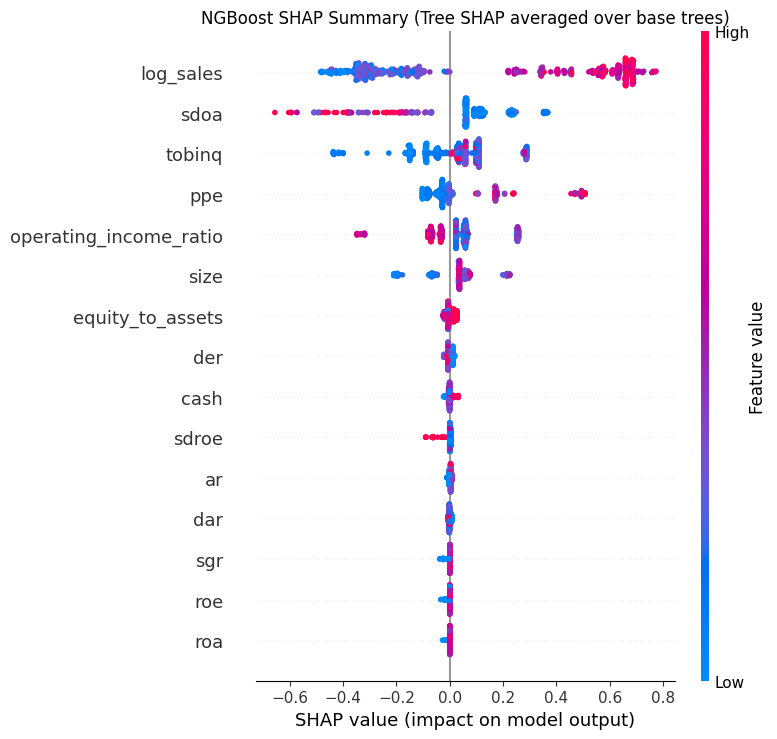

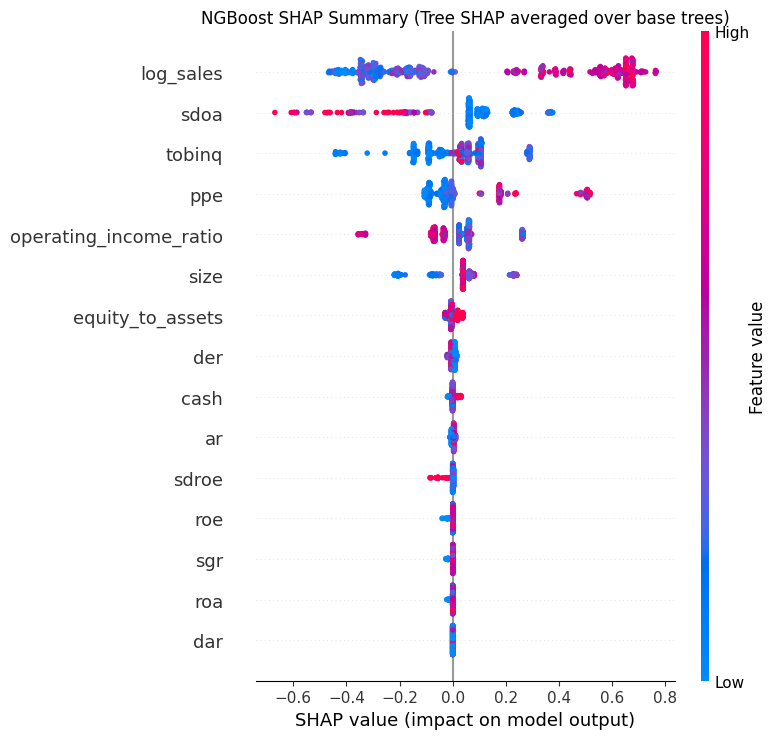

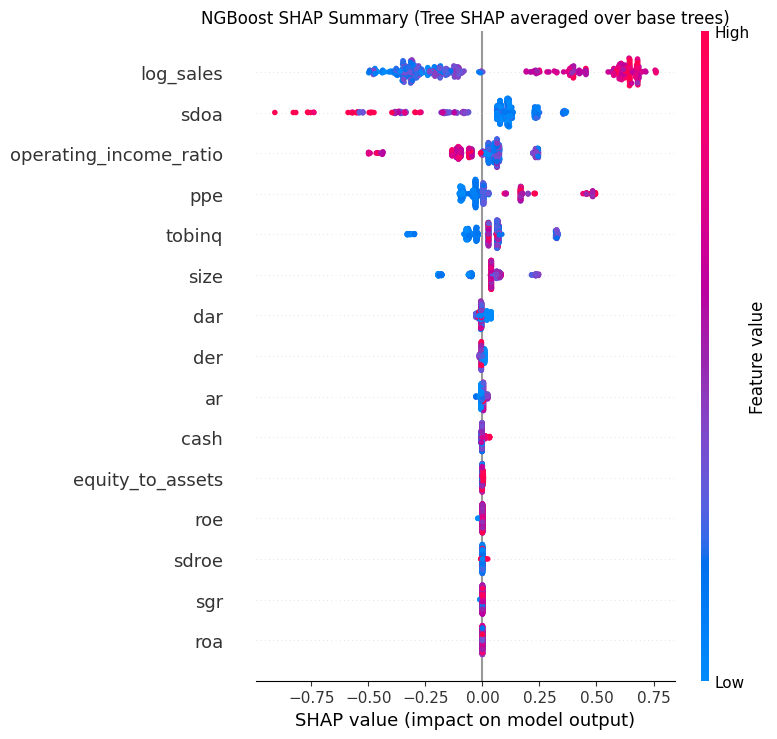

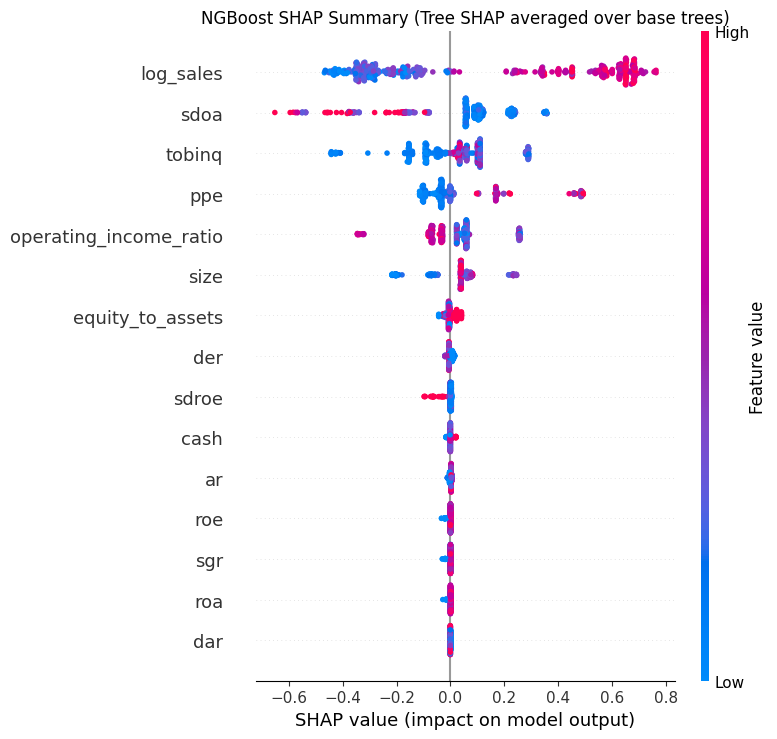

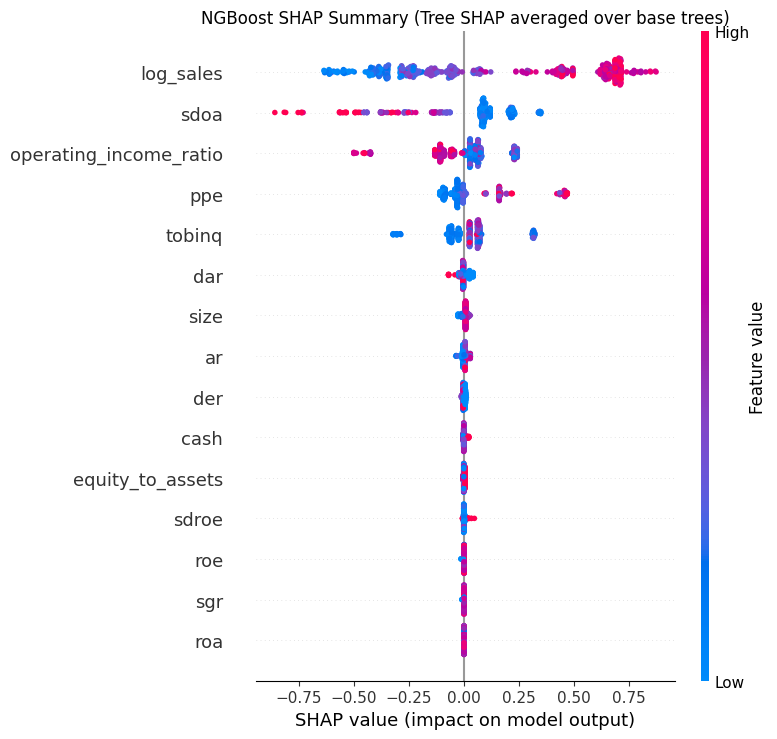

In [48]:
# ============================
# SHAP Summary Plot (Per Horizon)
# ============================

for h in [1, 2, 3, 4, 5]:
    plot_shap_ngboost_treeexplainer(
        ngb_model=models[h]["model"],
        X_train=models[h]["X_train"],
        feature_cols=feature_cols
    )

In [51]:
# ============================
# SHAP Feature Importance Bar Plot (Per Horizon)
# ============================
def plot_shap_feature_importance(
    model,
    model_type,
    X_train,
    feature_cols,
    horizon=None,
    sample_n=200,
    random_state=42
):
    """
    SHAP feature importance (bar plot)

    - TreeExplainer : xgb, rf, lgbm
    - NGBoost       : Tree SHAP (averaged over base trees)
    """

    # ============================
    # Sampling
    # ============================
    X_sample = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=random_state
    )

    # ============================
    # TREE-BASED MODELS
    # ============================
    if model_type in ["xgb", "rf", "lgbm"]:

        if model_type == "xgb":
            dshap = xgb.DMatrix(X_sample, feature_names=feature_cols)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(dshap)

        else:
            explainer = shap.TreeExplainer(model)
            shap_values_raw = explainer.shap_values(X_sample)

            # binary classifier → class 1
            if isinstance(shap_values_raw, list):
                shap_values = shap_values_raw[1]
            else:
                shap_values = shap_values_raw

    # ============================
    # NGBOOST (TREE SHAP, NO KERNEL)
    # ============================
    elif model_type == "ngboost":

        # extract base trees (1 tree per stage)
        trees = [stage[0] for stage in model.base_models]

        if len(trees) == 0:
            raise ValueError("No base trees found in NGBoost model")

        shap_sum = np.zeros((len(X_sample), X_sample.shape[1]))

        for tree in trees:
            explainer = shap.TreeExplainer(tree)
            shap_tree = explainer.shap_values(X_sample)
            shap_sum += shap_tree

        shap_values = shap_sum / len(trees)

    else:
        raise ValueError(
            "model_type must be 'xgb', 'rf', 'lgbm', or 'ngboost'"
        )

    # ============================
    # Plot
    # ============================
    model_name = MODEL_TITLE_MAP.get(model_type, model_type.upper())

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_sample,
        feature_names=feature_cols,
        plot_type="bar",
        show=False
    )

    title = f"SHAP Feature Importance – {model_name}"
    if horizon is not None:
        title += f" ({horizon}Y Horizon)"

    plt.title(title)
    plt.tight_layout()
    plt.show()

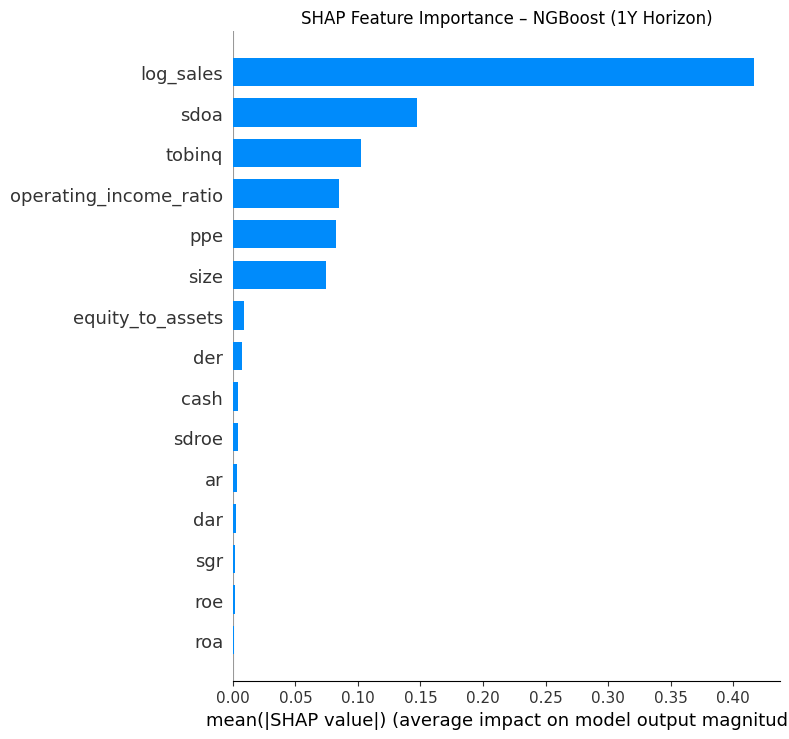

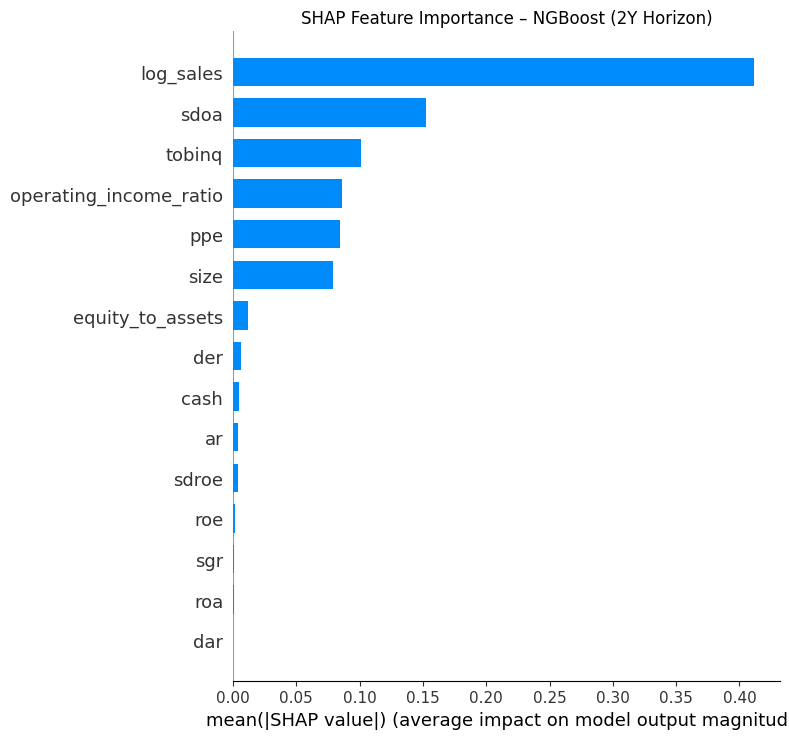

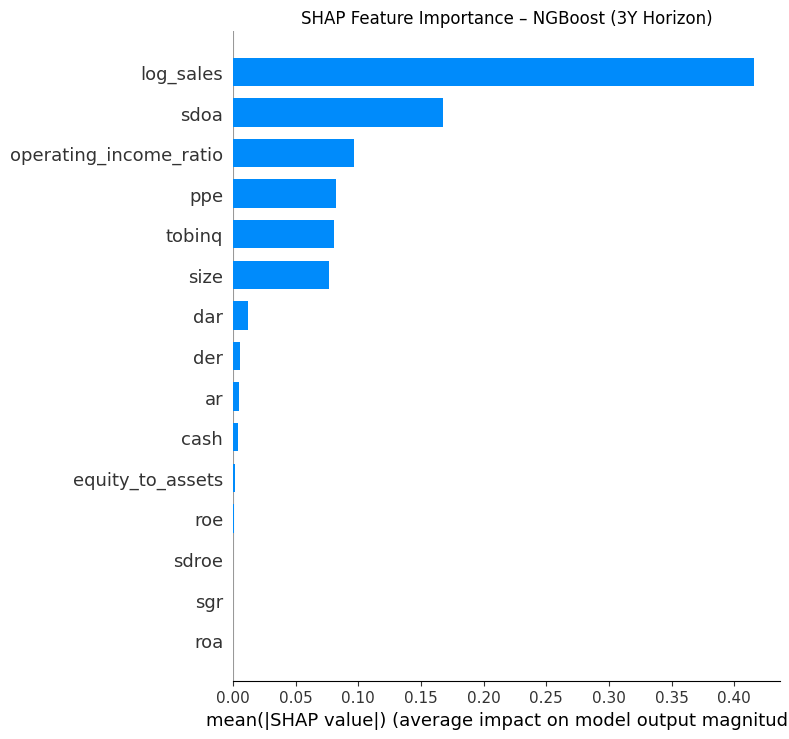

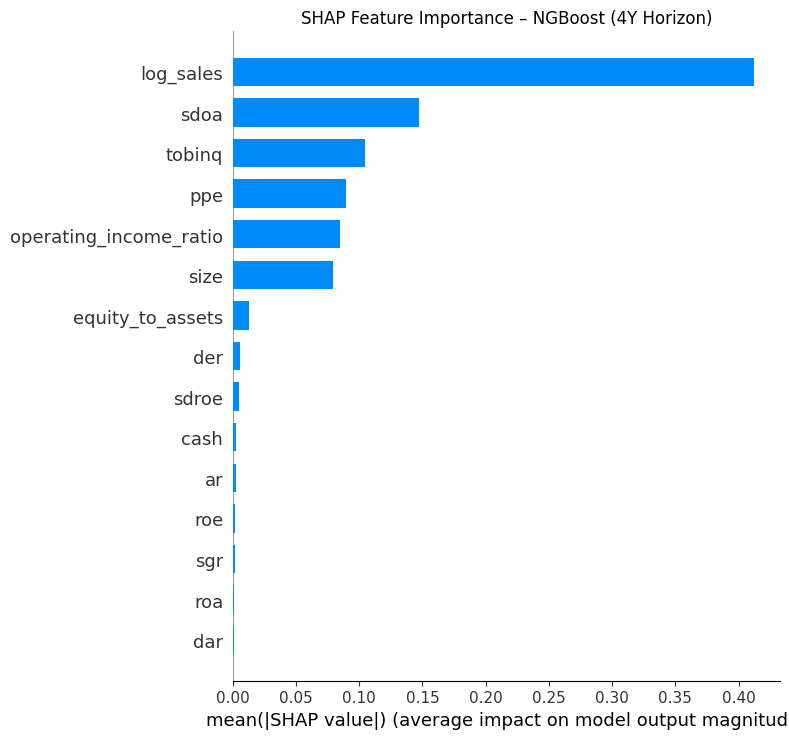

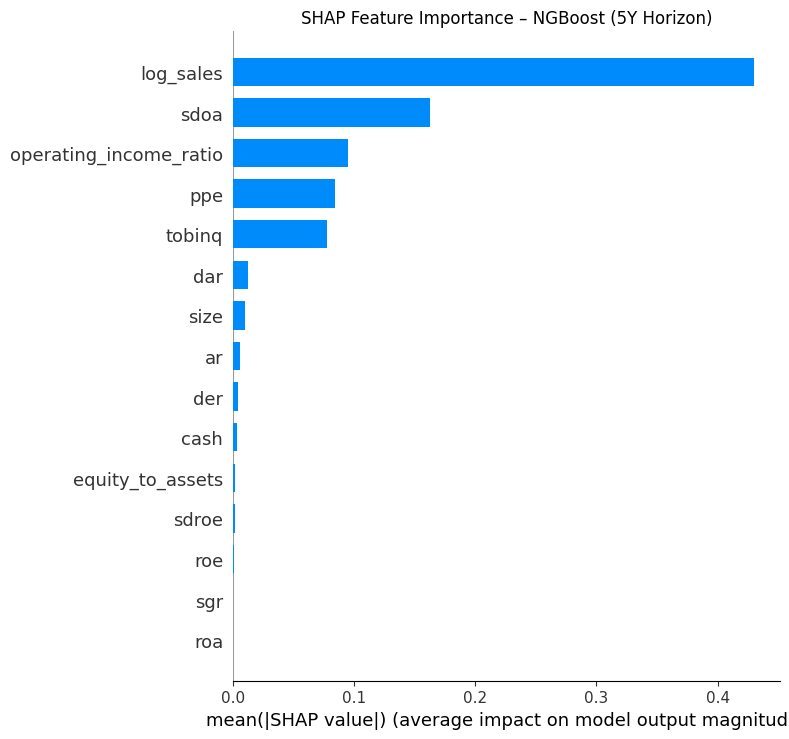

In [52]:
for h in [1, 2, 3, 4, 5]:
    plot_shap_feature_importance(
        model=models[h]["model"],
        model_type="ngboost",
        X_train=models[h]["X_train"],
        feature_cols=feature_cols,
        horizon=h
    )

In [49]:
# ============================
# SHAP Dependence Plot (Per Horizon)
# ============================

import shap
import xgboost as xgb
import matplotlib.pyplot as plt

top_features = [
    "log_sales",
    "ppe",
    "size",
    "operating_income_ratio",
    "dar",
    "sdoa",
]

def plot_shap_dependence(
    model_dict,
    top_features,
    model_type="ngboost",      # "xgb", "rf", "lgbm", "ngboost"
    sample_n=500
):
    """
    SHAP dependence plot for XGBoost, Random Forest, or LightGBM (per horizon)
    """

    model = model_dict["model"]
    horizon = model_dict["horizon"]
    X_train = model_dict["X_train"]

    print(f"\nSHAP Dependence – {model_type.upper()} {horizon}Y Horizon")

    # ============================
    # Sampling
    # ============================
    X_sample = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=42
    )

    # ============================
    # SHAP values
    # ============================
    if model_type == "xgb":
        dshap = xgb.DMatrix(X_sample)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(dshap)

    elif model_type in ["rf", "lgbm"]:
        explainer = shap.TreeExplainer(model)
        shap_values_raw = explainer.shap_values(X_sample)

        shap_values = (
            shap_values_raw[1]
            if isinstance(shap_values_raw, list)
            else shap_values_raw
        )
    
    elif model_type == "ngboost":
        # ============================
        # TRUE Tree SHAP for NGBoost
        # (average over base trees)
        # ============================
        trees = [stage[0] for stage in model.base_models]

        shap_sum = np.zeros((len(X_sample), X_sample.shape[1]))

        for tree in trees:
            explainer = shap.TreeExplainer(tree)
            shap_tree = explainer.shap_values(X_sample)
            shap_sum += shap_tree

        shap_values = shap_sum / len(trees)

    else:
        raise ValueError("model_type must be 'xgb', 'rf', or 'lgbm'")
    
    # ============================
    # Dependence plots
    # ============================
    for feat in top_features:
        if feat not in X_sample.columns:
            continue

        plt.figure(figsize=(6, 4))
        shap.dependence_plot(
            feat,
            shap_values,
            X_sample,
            show=False
        )
        model_name = MODEL_TITLE_MAP.get(model_type, model_type.upper())
        plt.title(f"{feat} – {model_name} SHAP Dependence ({horizon}Y)")
        plt.tight_layout()
        plt.show()


SHAP Dependence – NGBOOST 1Y Horizon


<Figure size 600x400 with 0 Axes>

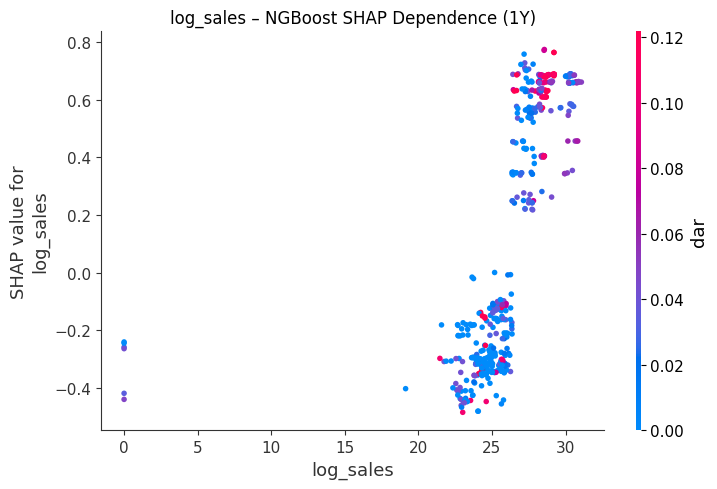

<Figure size 600x400 with 0 Axes>

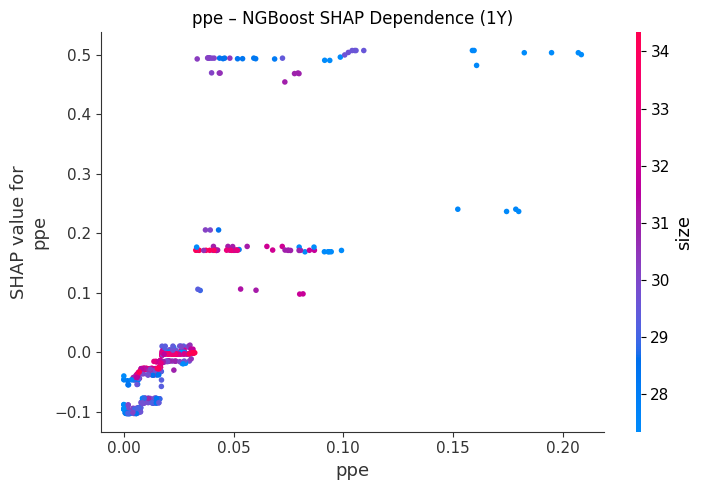

<Figure size 600x400 with 0 Axes>

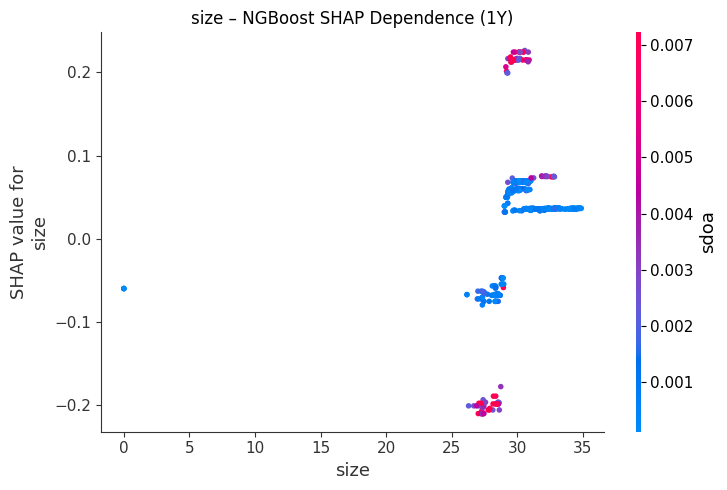

<Figure size 600x400 with 0 Axes>

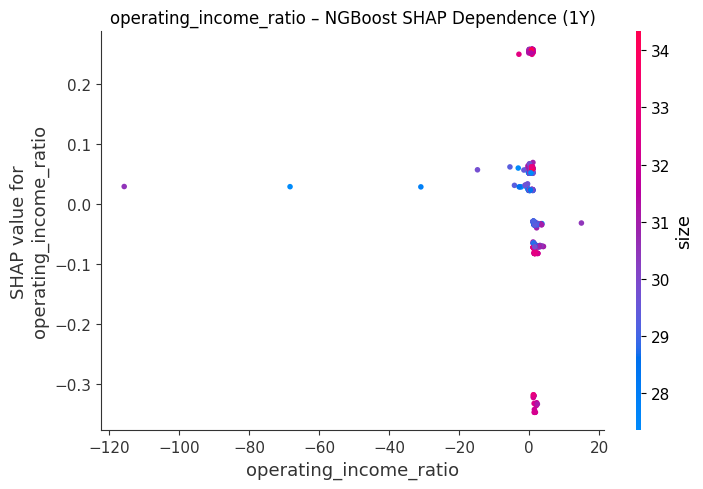

<Figure size 600x400 with 0 Axes>

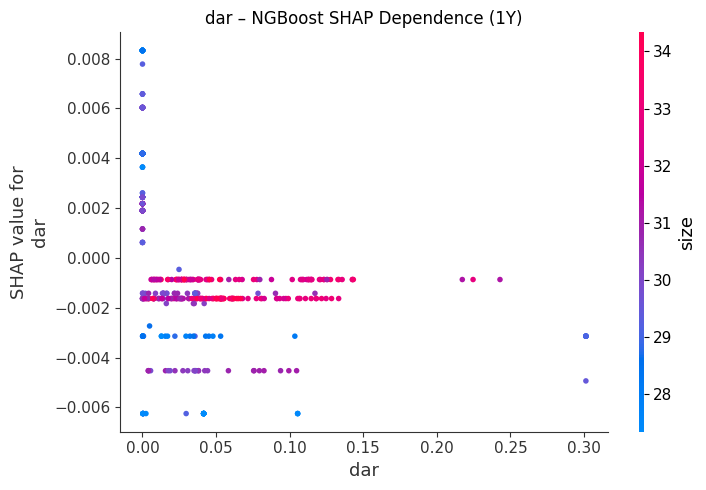

<Figure size 600x400 with 0 Axes>

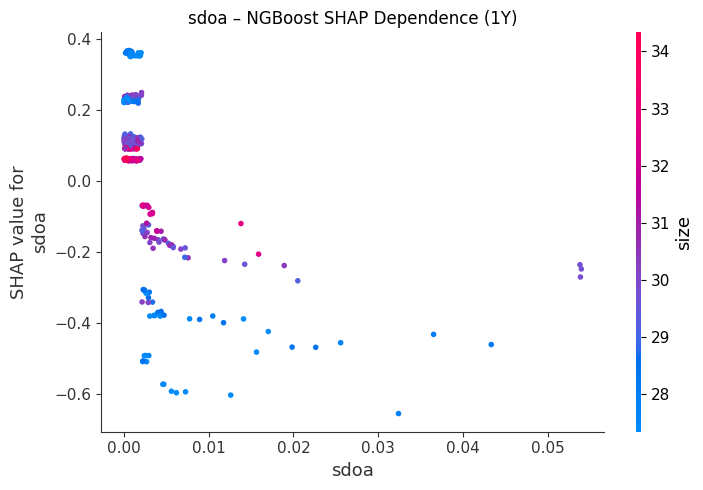


SHAP Dependence – NGBOOST 2Y Horizon


<Figure size 600x400 with 0 Axes>

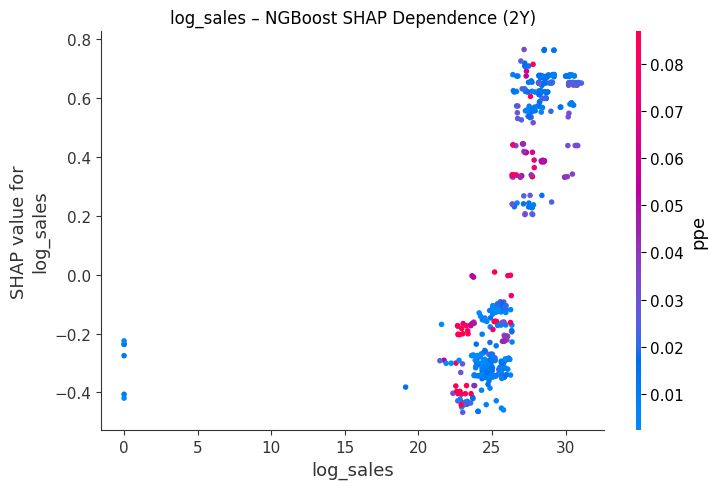

<Figure size 600x400 with 0 Axes>

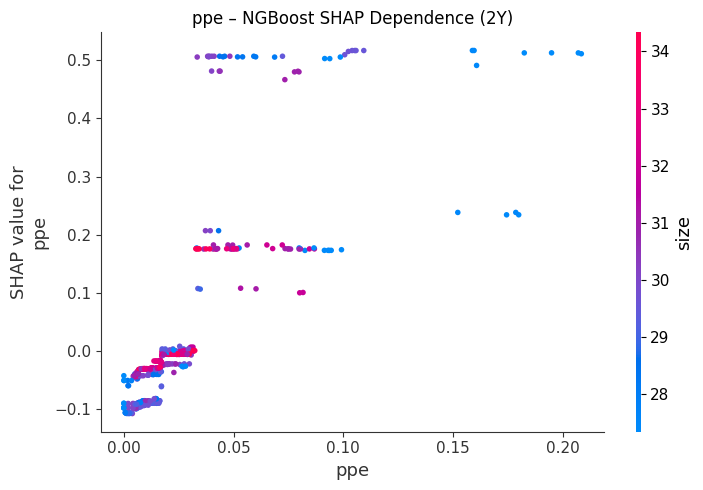

<Figure size 600x400 with 0 Axes>

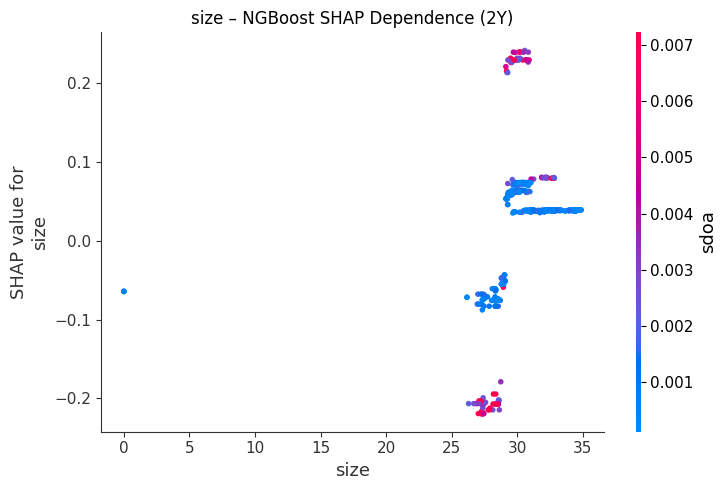

<Figure size 600x400 with 0 Axes>

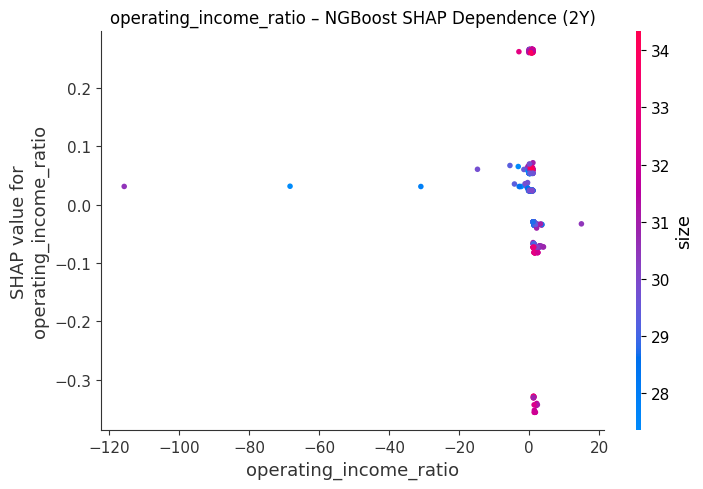

<Figure size 600x400 with 0 Axes>

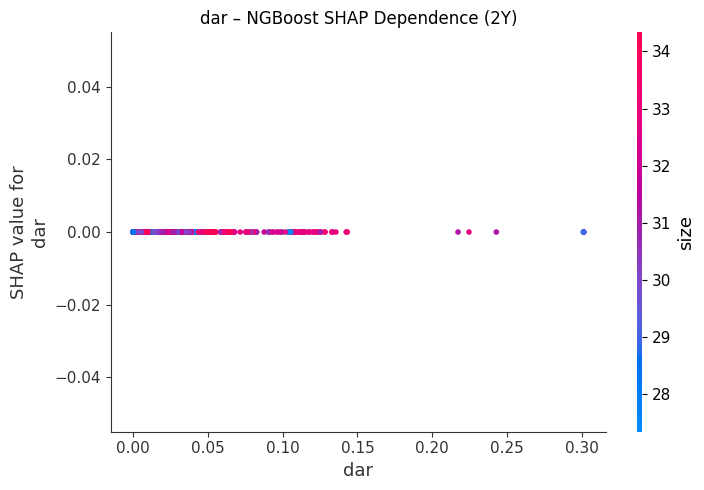

<Figure size 600x400 with 0 Axes>

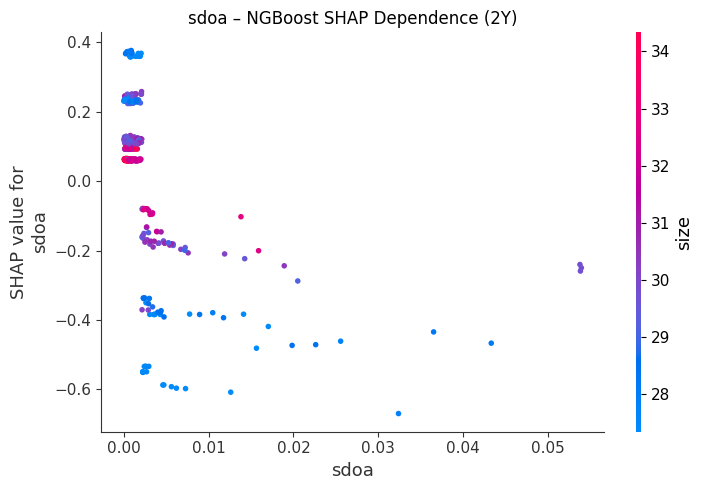


SHAP Dependence – NGBOOST 3Y Horizon


<Figure size 600x400 with 0 Axes>

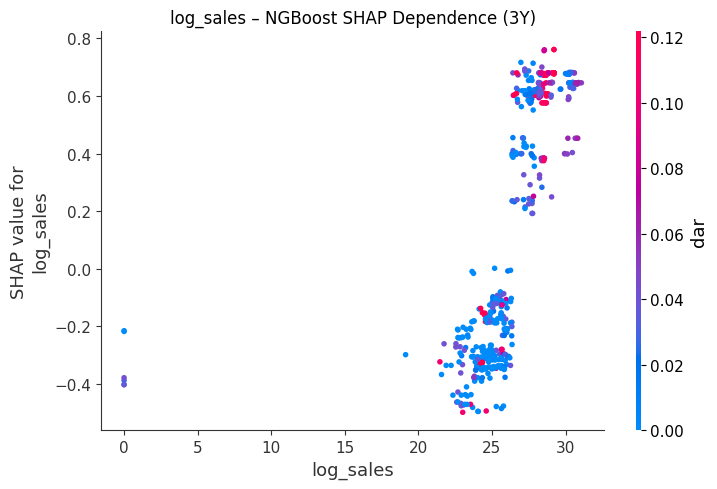

<Figure size 600x400 with 0 Axes>

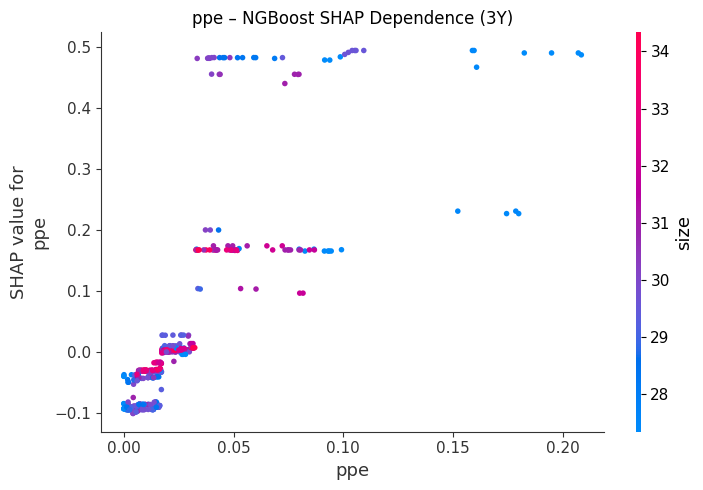

<Figure size 600x400 with 0 Axes>

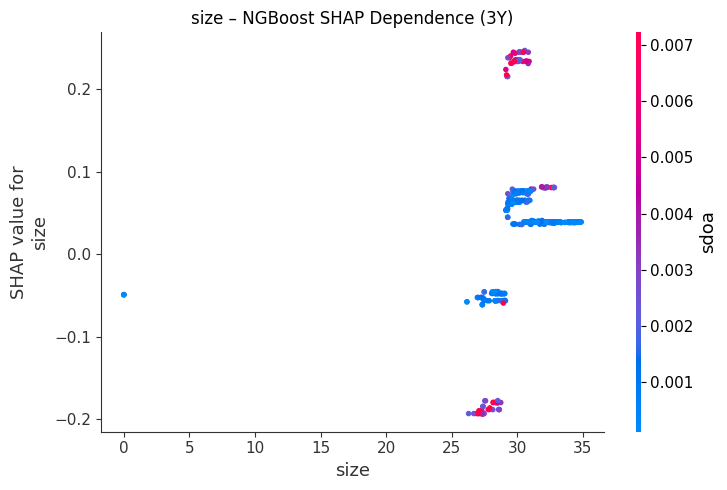

<Figure size 600x400 with 0 Axes>

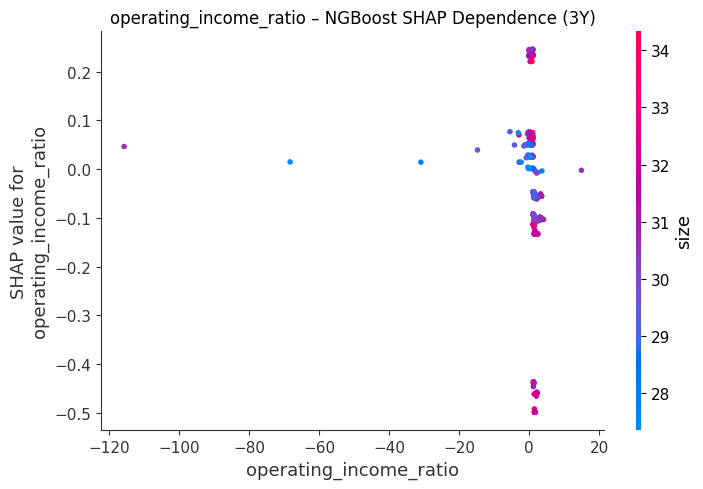

<Figure size 600x400 with 0 Axes>

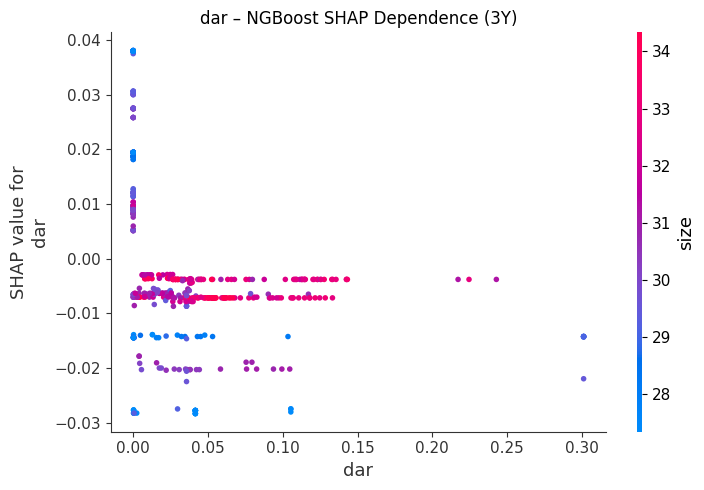

<Figure size 600x400 with 0 Axes>

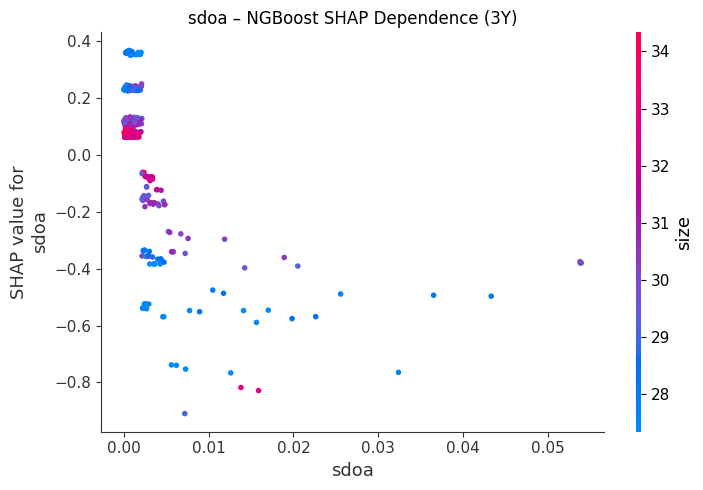


SHAP Dependence – NGBOOST 4Y Horizon


<Figure size 600x400 with 0 Axes>

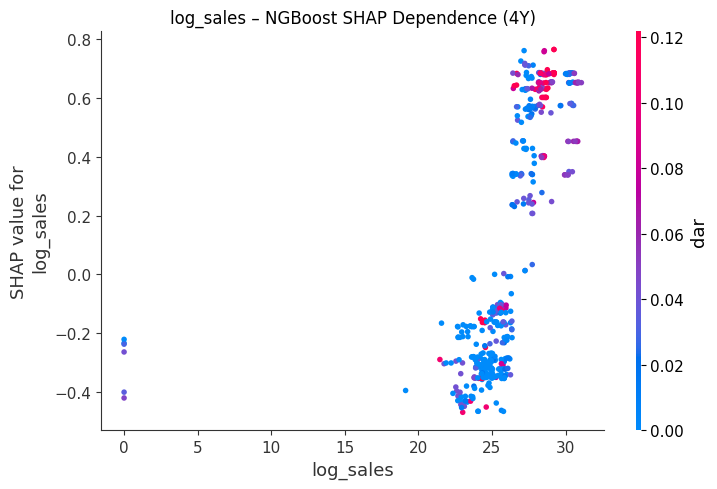

<Figure size 600x400 with 0 Axes>

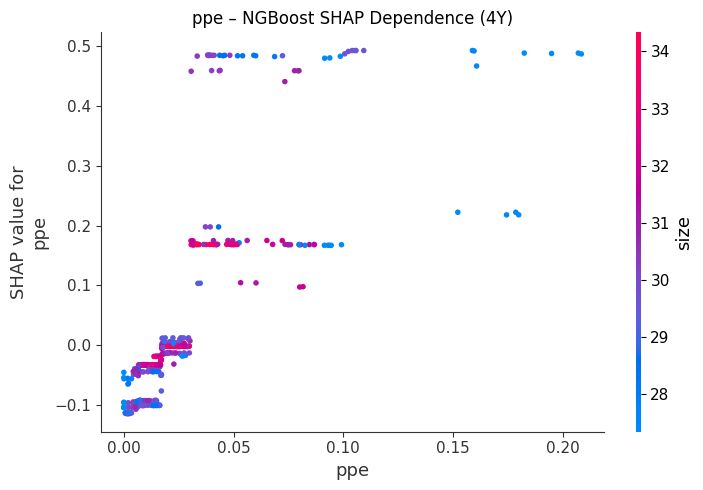

<Figure size 600x400 with 0 Axes>

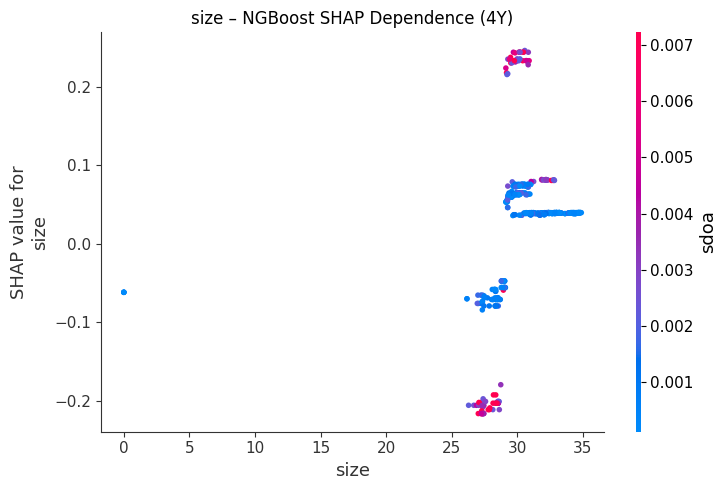

<Figure size 600x400 with 0 Axes>

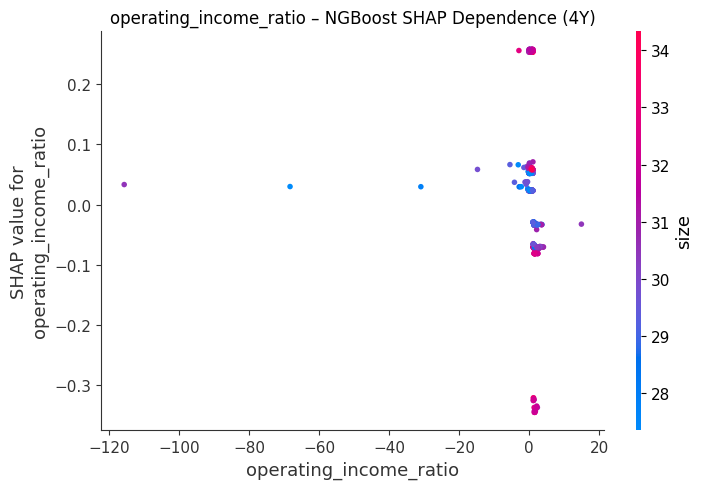

<Figure size 600x400 with 0 Axes>

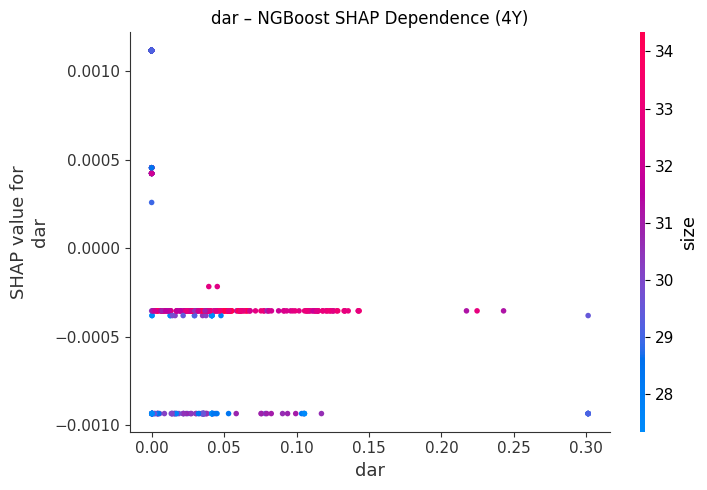

<Figure size 600x400 with 0 Axes>

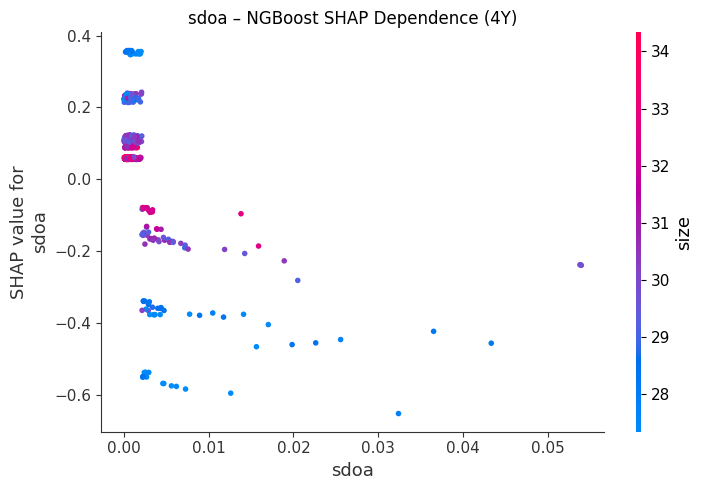


SHAP Dependence – NGBOOST 5Y Horizon


<Figure size 600x400 with 0 Axes>

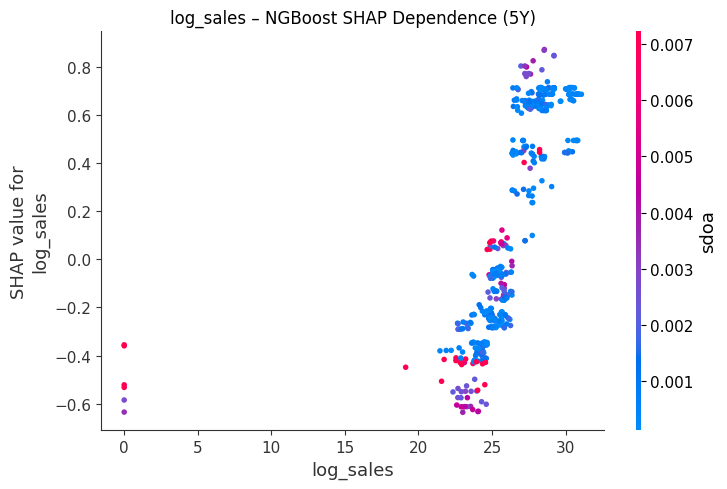

<Figure size 600x400 with 0 Axes>

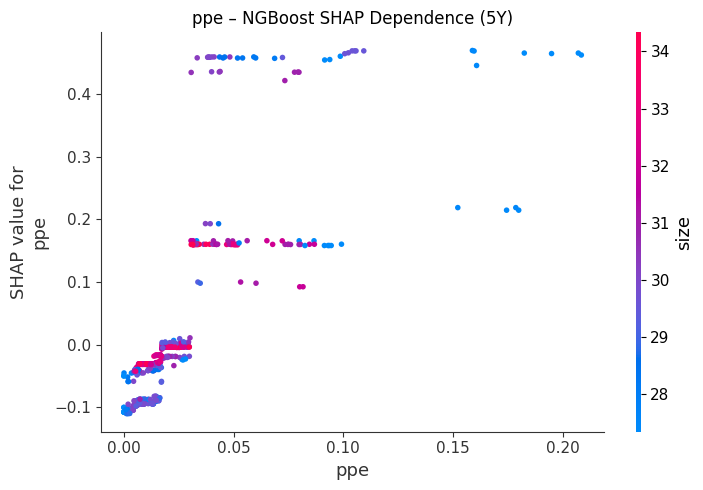

<Figure size 600x400 with 0 Axes>

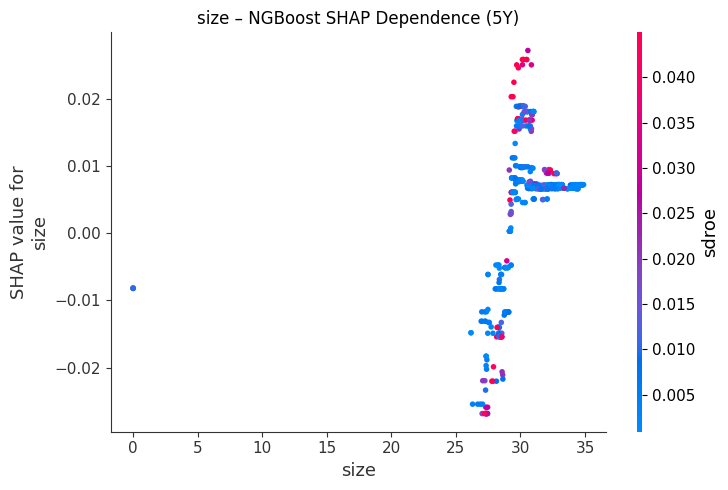

<Figure size 600x400 with 0 Axes>

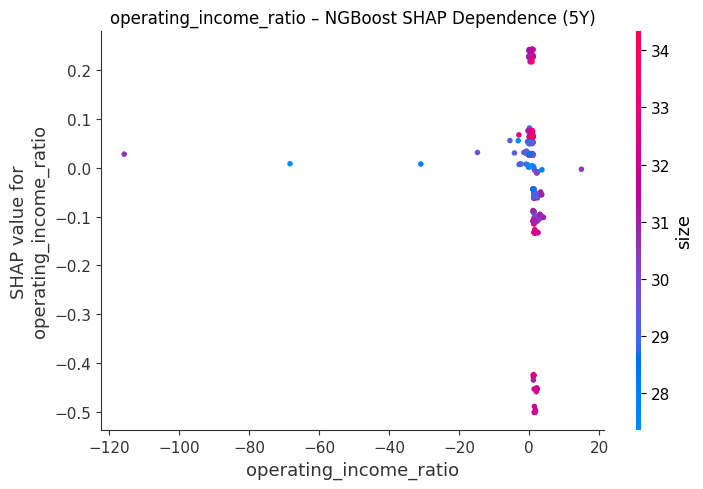

<Figure size 600x400 with 0 Axes>

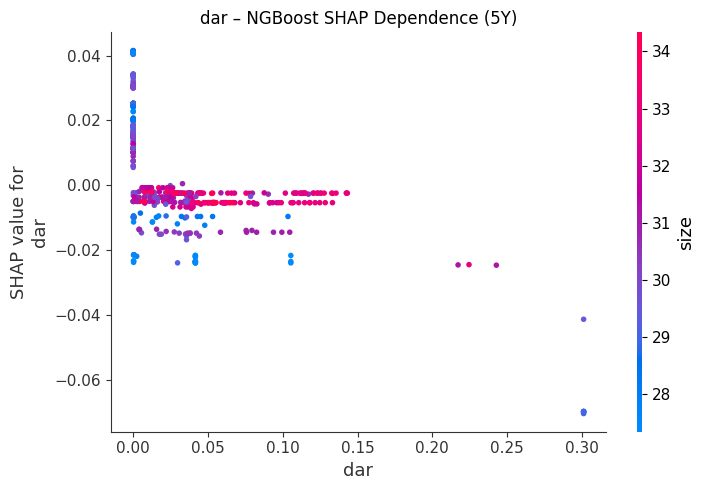

<Figure size 600x400 with 0 Axes>

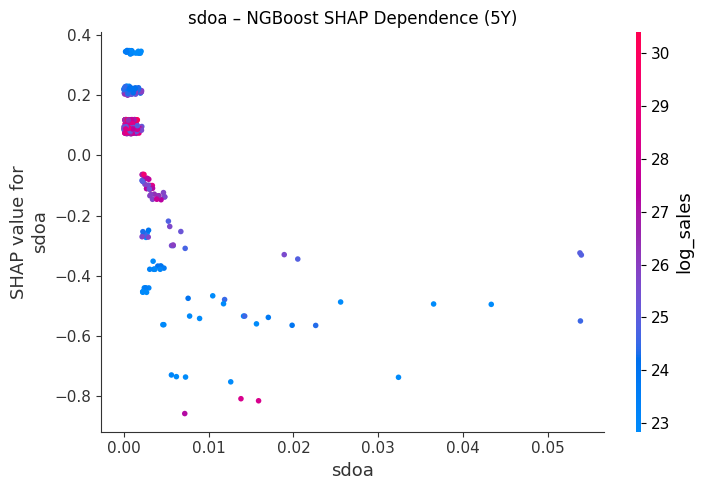

In [50]:
for h in [1, 2, 3, 4, 5]:
    plot_shap_dependence(
        model_dict=models[h],
        top_features=top_features,
        model_type="ngboost"
    )